<a href="https://colab.research.google.com/github/farghea/Pose-Detection-Biomechanics/blob/main/Deadlift_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yt-dlp
!apt-get install -y ffmpeg


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 99.4 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
import subprocess

def download_video(url, output_filename='myVideo.mp4'):
    temp_video = "temp_video.mp4"
    temp_audio = "temp_audio.m4a"

    command_video = f'yt-dlp -f "bestvideo[ext=mp4]" -o "{temp_video}" {url}'
    command_audio = f'yt-dlp -f "bestaudio[ext=m4a]" -o "{temp_audio}" {url}'
    command_merge = f'ffmpeg -i "{temp_video}" -i "{temp_audio}" -c copy "{output_filename}"'

    process_video = subprocess.Popen(command_video, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_video, stderr_video = process_video.communicate()
    if process_video.returncode != 0:
        print("Error downloading video:")
        print(stderr_video.decode("utf-8"))
        return

    process_audio = subprocess.Popen(command_audio, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_audio, stderr_audio = process_audio.communicate()
    if process_audio.returncode != 0:
        print("Error downloading audio:")
        print(stderr_audio.decode("utf-8"))
        return

    process_merge = subprocess.Popen(command_merge, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout_merge, stderr_merge = process_merge.communicate()
    if process_merge.returncode != 0:
        print("Error merging audio and video:")
        print(stderr_merge.decode("utf-8"))
    else:
        print(f"Video downloaded successfully as {output_filename}")

# YouTube video URL
video_url = 'https://www.youtube.com/watch?v=ytGaGIn3SjE'

download_video(video_url, 'myVideo.mp4')


Video downloaded successfully as myVideo.mp4


In [ ]:
!pip install moviepy
!pip install imageio-ffmpeg


In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip

# Define start and end times in seconds
start_time = 180 + 29
end_time = 180 + 31.3

# Load the video
video = VideoFileClip("myVideo.mp4")

# Cut the video
clip = video.subclip(start_time, end_time)

# Save the video
clip.write_videofile("myclip.mp4")


Moviepy - Building video myclip.mp4.
MoviePy - Writing audio in myclipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video myclip.mp4



Moviepy - Done !
Moviepy - video ready myclip.mp4


In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = 'myclip.mp4'
video_file = open(video_path, 'rb')
video_bytes = video_file.read()
video_url = 'data:video/mp4;base64,' + b64encode(video_bytes).decode()
HTML(f'<video width=400 controls><source src="{video_url}" type="video/mp4"></video>')


In [ ]:
# Create frames directory
!rm -r frames
!mkdir frames


rm: cannot remove 'frames': No such file or directory


In [ ]:
import cv2
import os

# Open the video file
vidcap = cv2.VideoCapture('myclip.mp4')

# Read the first frame
success,image = vidcap.read()
frame_count = 0

# Loop through all frames in the video
while success:
    # Save the current frame as a JPG image
    cv2.imwrite("frames/frame%d.jpg" % frame_count, image)

    # Read the next frame
    success,image = vidcap.read()
    frame_count += 1


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

model = hub.load('https://bit.ly/metrabs_l')  # Takes about 3 minutes


In [ ]:
import numpy as np

landmark_info = {
      'hip': [1, 2],
      'shoulder': [16, 17],
      'knee': [4, 5],
      'hand': [22, 23]}
def cal_mid_point(landmark_name, pred_pose):
  indx = landmark_info[landmark_name]
  pnt1 = pred_pose[indx[0], :]
  pnt2 = pred_pose[indx[1], :]
  mid_point = 0.5*(pnt1 + pnt2)
  return mid_point

def get_joint_point(landmark_name, pred_pose):
  indx = landmark_info[landmark_name]
  pnt1 = pred_pose[indx[0], :]
  pnt2 = pred_pose[indx[1], :]
  return np.vstack((pnt1, pnt2))


def estimate_3D_pose(jpg_file_name):
  myimg = tf.image.decode_image(tf.io.read_file(jpg_file_name))
  mypred = model.detect_poses(myimg, skeleton='smpl+head_30')

  pred_pose = mypred['poses3d'][0].numpy().reshape((30, 3))

  # lambda function to normalize a vector
  normalize = lambda vec: vec / np.linalg.norm(vec)

  # mid hip
  mid_hip = cal_mid_point('hip', pred_pose)

  # mid knee
  mid_knee = cal_mid_point('knee', pred_pose)

  # mid shoulder
  mid_shoulder = cal_mid_point('shoulder', pred_pose)

  # mid hand
  mid_hand = cal_mid_point('hand', pred_pose)

  # Shoulder length
  pnt1 = pred_pose[16, :]
  pnt2 = pred_pose[17, :]
  shoulder_length = np.linalg.norm(pnt2 - pnt1)

  # Flexion angle
  v1 = normalize(mid_shoulder - mid_hip)
  v2 = np.array([0, -1, 0])
  flexion_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))

  # - - - -
  v2 = np.array([0, -1, 0])
  v1 = mid_hand - mid_shoulder
  v1 = v1/np.linalg.norm(v1)
  hand_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))

  # hand to mid-hip distance (normalized to the shoulder distance)
  mid_hip_to_hand_distance = np.linalg.norm(mid_hand - mid_hip)/shoulder_length

  # hand to mid-hip distance (normalized to the shoulder distance)
  projection_matrix = np.array([1, 0, 1])
  mid_shoulder_to_hand_distance = np.linalg.norm(mid_hand*projection_matrix - mid_shoulder*projection_matrix)/shoulder_length

  # Asymmetry angle
  v1 = get_joint_point('shoulder', pred_pose)
  v2 = get_joint_point('hip', pred_pose)

  v1 = v1[0, :] - v1[1, :]
  v1[1] = 0
  v1 = v1/np.linalg.norm(v1)

  v2 = v2[0, :] - v2[1, :]
  v2[1] = 0
  v2 = v2/np.linalg.norm(v2)

  asymmetry_angle = np.rad2deg(np.arccos(np.dot(v1, v2)))

  return flexion_angle, mid_hip_to_hand_distance, asymmetry_angle, mid_shoulder_to_hand_distance, hand_angle



In [ ]:
analysis_results = {
    'time':   [],
    'flex_pose':   [],
    'dist_pose':    [],
    'asymmetry_angle': [],
    'shoulder_hand_dist': [],
    'hand_angle': []}

counter = 0
for i in range(frame_count):
  print(i)
  myfile = f'/content/frames/frame{i}.jpg'
  pose_estimation_parameters = estimate_3D_pose(myfile)

  analysis_results['time'].append(i)
  analysis_results['flex_pose'].append(pose_estimation_parameters[0])
  analysis_results['dist_pose'].append(pose_estimation_parameters[1])
  analysis_results['asymmetry_angle'].append(pose_estimation_parameters[2])
  analysis_results['shoulder_hand_dist'].append(pose_estimation_parameters[3])
  analysis_results['hand_angle'].append(pose_estimation_parameters[4])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68


In [ ]:
# Defining a function to plot results
joint_names = model.per_skeleton_joint_names['smpl+head_30'].numpy().astype(str)
joint_edges = model.per_skeleton_joint_edges['smpl+head_30'].numpy()

def plot_results(image, pred, joint_names, joint_edges):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib.patches import Rectangle

    plt.rcParams['font.size'] = 9
    fig = plt.figure(figsize=(18/2.54, 7/2.54))

    image_ax_no_pose = fig.add_subplot(1, 3, 1)
    image_ax_no_pose.imshow(image.numpy())

    image_ax = fig.add_subplot(1, 3, 2)
    image_ax.imshow(image.numpy())
    for x, y, w, h, c in pred['boxes'].numpy():
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    image_ax.set_xticklabels([])
    image_ax.set_yticklabels([])

    pose_ax = fig.add_subplot(1, 3, 3, projection='3d')
    pose_ax.view_init(0, 90)
    pose_ax.set_xlim3d(-1000+500, 1000+500)
    pose_ax.set_zlim3d(-1000, 1000)
    pose_ax.set_ylim3d(1500, 4500)

    poses3d = pred['poses3d'].numpy()
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, pred['poses2d'].numpy()):
        for i_start, i_end in joint_edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)
    pose_ax.set_xticklabels([])
    pose_ax.set_yticklabels([])
    pose_ax.set_zticklabels([])

    return fig


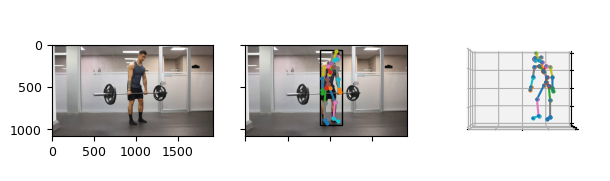

In [ ]:
# Plotting a selected frame
myfile = f'/content/frames/frame{50}.jpg'
img = tf.image.decode_image(tf.io.read_file(myfile))
pred = model.detect_poses(img, skeleton='smpl+head_30')
myfig = plot_results(img, pred, joint_names, joint_edges)

myfig.savefig('subplot_plot_deadlift_0.svg', format='svg', dpi=600)


In [ ]:
# Create giff directory
!rm -r giff_files
!mkdir giff_files


rm: cannot remove 'giff_files': No such file or directory


In [1]:
# Plotting some frames to create a giff
for i in range(0, frame_count, 3):
  print(i)
  myfile = f'/content/frames/frame{i}.jpg'
  img = tf.image.decode_image(tf.io.read_file(myfile))
  pred = model.detect_poses(img, skeleton='smpl+head_30')
  myfig = plot_results(img, pred, joint_names, joint_edges)

  myfig.savefig('giff_files/subplot_plot_deadlift_'+ str(i) +'.jpg', format='jpg', dpi=600)


In [ ]:
!zip -r giff_files.zip giff_files


  adding: giff_files/ (stored 0%)
  adding: giff_files/subplot_plot_deadlift_63.jpg (deflated 46%)
  adding: giff_files/subplot_plot_deadlift_48.jpg (deflated 46%)
  adding: giff_files/subplot_plot_deadlift_36.jpg (deflated 47%)
  adding: giff_files/subplot_plot_deadlift_57.jpg (deflated 46%)
  adding: giff_files/subplot_plot_deadlift_24.jpg (deflated 47%)
  adding: giff_files/subplot_plot_deadlift_9.jpg (deflated 47%)
  adding: giff_files/subplot_plot_deadlift_66.jpg (deflated 46%)
  adding: giff_files/subplot_plot_deadlift_42.jpg (deflated 46%)
  adding: giff_files/subplot_plot_deadlift_39.jpg (deflated 47%)
  adding: giff_files/subplot_plot_deadlift_21.jpg (deflated 47%)
  adding: giff_files/subplot_plot_deadlift_54.jpg (deflated 46%)
  adding: giff_files/subplot_plot_deadlift_60.jpg (deflated 46%)
  adding: giff_files/subplot_plot_deadlift_0.jpg (deflated 47%)
  adding: giff_files/subplot_plot_deadlift_27.jpg (deflated 47%)
  adding: giff_files/subplot_plot_deadlift_33.jpg (deflate

In [ ]:
# Save Results to csv
import pandas as pd

# Create the  data frame and save it
df = pd.DataFrame(analysis_results)
df.to_csv('my_results.csv', index=False)


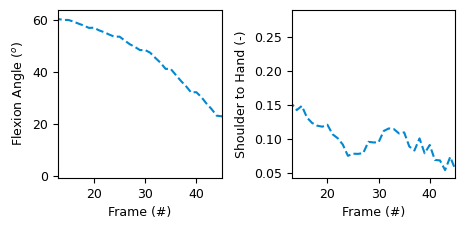

In [ ]:
import matplotlib.pyplot as plt

# plt.rcParams['font.family'] = 'verdana'
plt.rcParams['font.size'] = 9

# Set the plot size
cm = 1/2.54
fig, axs = plt.subplots(1, 2, figsize=(12*cm, 6*cm))

pose_det_color = '#0288d1'

# Flexion angle
axs[0].plot(np.array(range(frame_count)), analysis_results['flex_pose'], '--', color = pose_det_color)
axs[0].set_xlabel('Frame (#)')
axs[0].set_ylabel('Flexion Angle ($^o$)')
axs[0].set_xlim(13, 45)

# Shoulder distance
axs[1].plot(np.array(range(frame_count)), analysis_results['shoulder_hand_dist'], '--', color = pose_det_color)
axs[1].set_xlabel('Frame (#)')
axs[1].set_ylabel('Shoulder to Hand (-)')
axs[1].set_xlim(13, 45)


plt.tight_layout()

plt.savefig('subplot_plot.svg', format='svg', dpi=600)
